This notebook is necessary for the metabolic network visualization

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Map-top-quantities-to-pathways" data-toc-modified-id="Map-top-quantities-to-pathways-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Map top quantities to pathways</a></span><ul class="toc-item"><li><span><a href="#16S-KEGGs" data-toc-modified-id="16S-KEGGs-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>16S KEGGs</a></span></li><li><span><a href="#Shotgun-KEGGs" data-toc-modified-id="Shotgun-KEGGs-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Shotgun KEGGs</a></span></li><li><span><a href="#RNAseq-KEGGs" data-toc-modified-id="RNAseq-KEGGs-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>RNAseq KEGGs</a></span></li><li><span><a href="#Summarize-pathway-information" data-toc-modified-id="Summarize-pathway-information-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Summarize pathway information</a></span></li></ul></li><li><span><a href="#Map-KEGGs-to-compounds" data-toc-modified-id="Map-KEGGs-to-compounds-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Map KEGGs to compounds</a></span><ul class="toc-item"><li><span><a href="#16S" data-toc-modified-id="16S-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>16S</a></span></li><li><span><a href="#WGS" data-toc-modified-id="WGS-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>WGS</a></span></li><li><span><a href="#RNAseq" data-toc-modified-id="RNAseq-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>RNAseq</a></span></li></ul></li></ul></div>

In [1]:
# This block is just for importing the necessary libraries.  
import os
from collections import defaultdict
# Numerical libraries
import pandas as pd
import numpy as np
import biom
import arviz as az
from scipy.spatial.distance import euclidean
# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib_venn import venn2, venn3
# custom utility and plotting functions
from util import (extract_differentials, select_features, 
                  get_genomic_data, collapse_transcripts, 
                  aggregate_pathways,
                  ranking, btest, log_pvalue, read_kegg_dict,
                  ilr_transform_differentials,
                  rename_clades, create_projection,
                  match_all_differentials)
from plot import (rankplot, networkplot, vectorplot)
import random

# directory paths
amp_directory = '../sfari/data/sra/Combined'
wgs_directory = '../sfari/data/sra_shotgun/Combined'
rna_directory = '../sfari/data/recount3'
kang_directory = '../sfari/data/sra/Kang2017'
sepp_directory = '../sfari/data/sra/Kang2017/deblur/sepp'
results_dir = '../results'
kegg_dir = f'{results_dir}/kegg'
hsa_dir = f'{results_dir}/hsa_kegg'
np.random.seed(0)
random.seed(0)
%matplotlib inline

In [2]:
# load 16S, whole genome shotgun and RNAseq data
posterior_name = os.path.join('age_sex_matched_posterior',
                              'differential_posterior.nc')
amp_fname = f'{amp_directory}/{posterior_name}'
wgs_fname = f'{wgs_directory}/{posterior_name}'
rna_fname = f'{rna_directory}/{posterior_name}'
amp_diffs = extract_differentials(amp_fname)
wgs_diffs = extract_differentials(wgs_fname)
rna_diffs = extract_differentials(rna_fname)

# Compute statistical tests for each data layer
# Here, we will only focus on the top 5% of the features
amp_stats = ranking(amp_diffs, reference_percentile=95)
wgs_stats = ranking(wgs_diffs, reference_percentile=95)
rna_stats = ranking(rna_diffs, reference_percentile=95)

# Map top quantities to pathways

We will take the taxa and transcripts that passed the thresholds and map them to KEGGs
1. For 16S, we will pull out Picrust annotations and use a binomial test to perform a comparative genomics analysis
2. For shotgun, we will use the Woltka stratification and apply the same binomial test
3. For RNAseq, we will map Ensembl ids to Uniprot and then KEGG

## 16S KEGGs

## Shotgun KEGGs

In [58]:
# Perform binomial test on shotgun metagenomics data
# Place hard threshold to select top ASD associated microbes
# Obtain presence-absence tables of microbes and their 
# corresponding KEGG genes in the shotgun data
wgs_con, wgs_asd = select_features(wgs_stats, alpha=0.1)
ko_ogu = get_genomic_data(f'{wgs_directory}/table_func.biom')
kegg_con_wgs = ko_ogu.align(wgs_con, axis=0, join='inner')[0]
kegg_asd_wgs = ko_ogu.align(wgs_asd, axis=0, join='inner')[0]

#kegg_con_wgs, kegg_asd_wgs = btest(kegg_con_wgs, kegg_asd_wgs)
#kegg_asd_wgs = log_pvalue(kegg_asd_wgs, alpha=0.1)

# apply binomial test.  Use BH correction to get per-gene pvalues
res = btest(kegg_con_wgs, kegg_asd_wgs, return_proportions=True)
res = log_pvalue(res.reset_index().rename(columns={'pval': 'pvalue', 'index': 'KEGG'}))
res = res.query("side == 'groupA'")

sig_wgs = aggregate_pathways(
    pathway_name_file=f'{kegg_dir}/pathway_name.txt',
    pathway_to_ko_file=f'{kegg_dir}/pathway-to-ko.txt',
    features=res
)

## RNAseq KEGGs

In [24]:
# Visualize KEGG counts for RNAseq data 
rna_con, rna_asd = select_features(rna_stats)
fname = f'{rna_directory}/ensembl2kegg.txt'
ensembl2ko = pd.read_table(fname, index_col=0)
ensembl2ko = ensembl2ko.set_index('gene_stable_id')
rna_asd = collapse_transcripts(rna_asd)
kegg_asd_rna = pd.merge(ensembl2ko, rna_asd, 
                        left_index=True, right_index=True)
kegg_asd_rna = kegg_asd_rna[['KO', 'pvalue']]
kegg_asd_rna = kegg_asd_rna.groupby('KO').mean()
kegg_asd_rna = log_pvalue(kegg_asd_rna, alpha=0.1)
split_func = lambda x: x.split(':')[-1]
#kegg_asd_rna['HSA'] = kegg_asd_rna['KEGG']
kegg_asd_rna['KEGG'] = kegg_asd_rna['KO'].apply(split_func)

sig_rna = aggregate_pathways(
    pathway_name_file=f'{hsa_dir}/pathway_name.txt',
    pathway_to_ko_file=f'{hsa_dir}/ko-to-pathway.txt',
    features=kegg_asd_rna,
    columns=['HSA', 'Pathway']
)

sig_rna = sig_rna.query("side == 'groupA'")

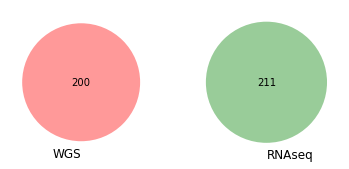

In [35]:
# Venn diagram to visualize overlap
venn2([#set(kegg_asd_amp.index), 
       set(kegg_asd_wgs.index), 
       set(kegg_asd_rna.index)], 
      set_labels=['WGS', 'RNAseq'])

## Summarize pathway information

In [51]:
#df1 = pd.DataFrame(kegg_asd_amp, columns=['KEGG'])
df2 = pd.DataFrame(kegg_asd_wgs, columns=['KEGG'])
df3 = pd.DataFrame(kegg_asd_rna, columns=['KEGG'])
#df1['TYPE'] = '16S'
df2['TYPE'] = 'Shotgun'
df3['TYPE'] = 'RNAseq'
sig_keggs = pd.concat((df2, df3), axis=0)

In [52]:
sig_keggs = sig_keggs.rename(columns={'KEGG': '#KEGG'})
sig_keggs.to_csv('../results/WGS_RNAseq_keggs.txt', sep='\t', index=None)

# Map KEGGs to compounds

## 16S

## WGS

In [90]:
kegg_dir = '../results/kegg'

pwy2kegg = read_kegg_dict(f'{kegg_dir}/pathway-to-ko.txt', 
                          ['Pathway', 'KO'])

pwy_name = pd.read_table(f'{kegg_dir}/pathway_name.txt', header=None)
pwy_name.columns = ['Pathway', 'Name']
pwy2kegg = pd.merge(pwy2kegg, pwy_name, left_on='Pathway', right_on='Pathway')

lookup = {d: i for i, d in enumerate(pwy2kegg['Name'].value_counts().index)}
pwy2kegg['ID'] = pwy2kegg['Name'].apply(lambda x: lookup[x])

#sig_WGS = pd.merge(pwy2kegg, sig_wgs, left_on='KO', right_on='KEGG').drop_duplicates()
pwy2kegg = pwy2kegg.set_index('Pathway')

pwy2compound = read_kegg_dict(f'{kegg_dir}/pathway-to-compound.txt', 
                              ['Pathway', 'Compound'])
sig_WGS = pd.merge(sig_wgs, pwy2compound, left_on='Pathway', right_on='Pathway')
sig_WGS.to_csv('../results/WGS_compounds.csv')

## RNAseq

In [87]:
hsa_dir = '../results/hsa_kegg'

pwy2kegg = read_kegg_dict(f'{hsa_dir}/ko-to-pathway.txt', 
                          ['HSA', 'Pathway'])

pwy_name = pd.read_table(f'{hsa_dir}/pathway_name.txt', header=None)
pwy_name.columns = ['Pathway', 'Name']
pwy2kegg = pd.merge(pwy2kegg, pwy_name, left_on='Pathway', right_on='Pathway')
lookup = {d: i for i, d in enumerate(pwy2kegg['Name'].value_counts().index)}
pwy2kegg['ID'] = pwy2kegg['Name'].apply(lambda x: lookup[x])
pwy2kegg = pwy2kegg.set_index('Pathway')

#sig_RNA = pd.merge(pwy2kegg, sig_rna, left_on='HSA', right_on='HSA').drop_duplicates()
 
pwy2compound = read_kegg_dict(f'{hsa_dir}/pathway-to-compound.txt', 
                              ['Pathway', 'Compound'])
sig_RNA = pd.merge(sig_rna, pwy2compound, left_on='Pathway', right_on='Pathway')
sig_RNA.to_csv('../results/RNA_compounds.csv')

In [89]:
sig_wgs.to_csv('../results/supplemental_tables/Table_S11.csv')
sig_rna.to_csv('../results/supplemental_tables/Table_S12.csv')